In [1]:
'''
Original Script by Josh Rabinowitz
'''
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,3)

import numpy as np
import glob
from scipy import interpolate

In [2]:
import numpy as np
import pandas as pd
import scipy
from natsort import natsorted
import pathlib
import posixpath

In [3]:
# opens and plots GC data. This code throws out the first 25 lines of data, and goes until the last line of data 
# using the 15 minute GC 80 degrees C program. Splits lines by comma. 
# This function also includes the detect peaks function which you found on the internet
def plot_GC_data(filepath, line1, line2):
    with open(filepath,'r') as f: #open file
        lines = f.readlines()[line1:line2] #make an array of lines that include data
    xvalues = []
    yvalues = []
    for line in lines:
        if line.strip() == '':
            continue
        else:
            Type = line.split(",") #split each line by the comma
            yval = int(Type[0]) #only considering first column of data, convert to int
            yvalues.append(yval)
    xvalues = np.linspace(0,540,540*5-1)
    
    plt.plot(xvalues, yvalues)
    # filename = os.path.splitext(os.path.basename(filepath))[0]
    # plt.title(filename)
    plt.xlabel("Retention time (seconds)")
    plt.ylabel("Intensity")
    # plt.savefig(filename + '.png', dpi=600)
    
    plt.show

In [4]:
# For 9 minute CO program, the plot values are: 26,5424
# plot_GC_data('', 
   #          26,5424)

In [5]:
# Right now, you have filepath, but you probably want this input to be the index of the array created by glob.glob
def integrate_peak(filepath, xleft, xright, thresh, smooth, gas):
    
    with open(filepath, 'r') as f:
    # Define first and last lines to be read from ASC file. The data starts at line 25. 
        lines = f.readlines()[25:5424]
        
        newlines=[]
        for line in lines:
            if line.strip() == '':
                continue
            else:
                newlines.append(line)
        # The step size is 0.2, so multiply the x position by 5 and add 25 to convert to line number
        line1 = xleft*5 + 25
        line2 = xright*5 + 25
        
        newlinesarray = newlines[line1:line2]

        # Fill arrays for x and y values with first column of data points from the ASC file

        xvalues = []
        yvalues = []
        for line in newlinesarray:
            Type = line.split(",")        
            yval = int(Type[0])
            xvalues = np.linspace(xleft, xright, (line2 - line1))
            yvalues.append(yval)
        
        
        # spline fit the data with smooth factor of 1000. the order of the fit polynomial, k=5
        # so to smooth the second derivative of the spline fit as much as possible.

        tck = interpolate.splrep(xvalues, yvalues, k=3, s=smooth)
        xnew = []
        ynew = []
        xnew = np.arange(xleft, xright, 0.2)
        ynew = interpolate.splev(xnew, tck, der=0)

        # take derivative of the spline fit 

        yder = interpolate.splev(xnew, tck, der=1)

        # take second derivative of the spline fit

        y2der = interpolate.splev(xnew, tck, der=2)
        
        if np.amax(y2der) < thresh:
            print('no peak')
            return 0

        # Find the left edge of the peak, assuming edge of peak starts when 2nd der >= thresh      
        
        global left_edge_idx, garb1_edge_idx, garb2_edge_idx, garb3_edge_idx
        
        for idx, x in zip(range(0,len(xnew)), xnew):
            if y2der[idx] >= thresh:
                left_edge = x
                left_edge_idx = idx
                break 
        
        # Find the right edge of the peak, assuming edge of peak starts when 2nd der >= thresh      
        
        for idx, x in zip(reversed(range(0,len(xnew))), xnew):
            if y2der[idx] >= thresh:
                right_edge = x
                right_edge_idx = idx
                break
        

        # Set up arrays that only include the peaks
        xpeak = xnew[left_edge_idx:right_edge_idx]
        ypeak = ynew[left_edge_idx:right_edge_idx]

        # Set up baseline function as a straight line between the two peak edges

        m = (ypeak[right_edge_idx - left_edge_idx - 1] - ypeak[0])/(xpeak[right_edge_idx - left_edge_idx - 1] - xpeak[0])
        b = ypeak[0] - m * xpeak[0]
        y_base = m * xpeak + b
        plt.figure()
        plt.plot(xpeak, ypeak, xpeak, y_base, 'r')
        plt.legend(['Spline', 'Baseline'])
        plt.title(gas +' Spline with Baseline')
#         plt.savefig(gas + 'splinewithbaseline.png', dpi=600)

        plt.show()

        #Subtract the baseline from the peak

        y_base_corr = []
        for y, z in zip(ypeak, y_base):
            y_bc = y - z
            y_base_corr.append(y_bc)
        plt.figure()
        plt.plot(xpeak, y_base_corr)
        plt.title(gas + ' Baseline Corrected')
#         plt.savefig(gas + 'baselinecorrected.png', dpi=600)
        plt.show()

        '''for idx, x, y in zip(range(0,len(xnew)), xnew, y2der):
                    print(idx,x, y) '''      

        #Integrate the Baseline Corrected peak

        integral = np.trapz(y_base_corr, dx=0.2)
        print(integral)
        return integral

In [6]:
# def integrate_peak(filepath, xleft, xright, thresh, smooth, gas)

# integrate_peak('',
 #              230, 310, 50, 100, 'CO')

#integrate_peak('',
 #              246, 261, 150000, 100, 'ch4')

# integrate_peak('',
#               465, 500, 50, 100, 'c2h4')

# integrate_TCD_peak('',
           #        90, 110, 30, 100)

# handle_GC_data(
 #   ''
  #  ,26, 5424, # overallleft, overallright,
   # 230, 310, 50, # COleft, COright, COthresh,
    # 246, 261, 150000, # CH4left, CH4right, CH4thresh,
    # 440, 510, 50, # C2H4left, C2H4right, C2H4thresh,
    # 85, 110, 30, # H2left, H2right, H2thresh
    # 100) # smooth

In [7]:
# Right now, you have filepath, but you probably want this input to be the index of the array created by glob.glob
def integrate_TCD_peak(filepath, xleft, xright, thresh, smooth):
    
    with open(filepath, 'r') as f:
    # Define first and last lines to be read from ASC file. The data starts at line 25, and the step size is 0.2,
    # so I multiply the x position by 5 and add 25 to convert to line number
        lines = f.readlines()[25:5424]
        newlines=[]
        for line in lines:
            if line.strip() == '':
                continue
            else:
                newlines.append(line)
        
        line1 = xleft*5 + 25
        line2 = xright*5 + 25
        
        
        newlinesarray = newlines[line1:line2]
        
        xvalues = []
        yvalues = []
        for line in newlinesarray:
            Type = line.split(",")
            yval = -int(Type[0])
            xvalues = np.linspace(xleft, xright, (line2 - line1))
            yvalues.append(yval)
        # plt.plot(xvalues,yvalues)    
        # spline fit the data with smooth factor of 1000. the order of the fit polynomial, k=5
        # so to smooth the second derivative of the spline fit as much as possible.

        tck = interpolate.splrep(xvalues, yvalues, k=3, s=smooth)
        xnew = []
        ynew = []
        xnew = np.arange(xleft, xright, 0.2)
        ynew = interpolate.splev(xnew, tck, der=0)

        # take derivative of the spline fit

        yder = interpolate.splev(xnew, tck, der=1)

        # take second derivative of the spline fit

        y2der = interpolate.splev(xnew, tck, der=2)
        
        if np.amax(y2der) < thresh:
            print('no peak')
            return 0

        # Find the left edge of the peak, assuming edge of peak starts when 2nd der >= thresh      
        
        global left_edge_idx, garb1_edge_idx, garb2_edge_idx, garb3_edge_idx
        
        for idx,x in zip(range(0,len(xnew)), xnew):
            if y2der[idx] >= thresh:
                left_edge = x
                left_edge_idx = idx
                break
        
        # Find the right edge of the peak, assuming edge of peak starts when 2nd der >= thresh      
        
        for idx,x in zip(reversed(range(0,len(xnew))), xnew):
            if y2der[idx] >= thresh:
                right_edge = x
                right_edge_idx = idx
                break
        

        # Set up arrays that only include the peaks
        xpeak = xnew[left_edge_idx:right_edge_idx]
        ypeak = ynew[left_edge_idx:right_edge_idx]

        # Set up baseline function as a straight line between the two peak edges

        m = (ypeak[right_edge_idx - left_edge_idx-1] - ypeak[0]) / (xpeak[right_edge_idx - left_edge_idx-1] - xpeak[0])
        b = ypeak[0] - m * xpeak[0]
        y_base = m * xpeak + b
        plt.figure()
        plt.plot(xpeak, ypeak, xpeak, y_base, 'r')
        plt.legend(['Spline','Baseline'])
        plt.title('H2 Spline with Baseline')
#         plt.savefig('h2splinewithbaseline.png', dpi=600)
        plt.show()

        # Subtract the baseline from the peak

        y_base_corr = []
        for y, z in zip(ypeak, y_base):
            y_bc = y - z
            y_base_corr.append(y_bc)
        plt.figure()
        plt.plot(xpeak, y_base_corr)
        plt.title('H2 Baseline Corrected')
#         plt.savefig('h2baselinecorrected.png', dpi=600)
        plt.show()

        '''for idx,x,y in zip(range(0,len(xnew)), xnew, y2der):
                    print(idx, x, y) '''      

        # Integrate the Baseline Corrected peak

        integral = np.trapz(y_base_corr, dx=0.2)
        print(integral)
        return integral

In [8]:
# For 9 minute CO program, the plot values are: 26,5424
# TYPICAL CO 9 MIN RAMP PEAK VALUES:
# COleft=180
# COright=220
# COthresh=280
# CH4left=200
# CH4right=250
# CH4thresh=1000
# C2H4left=460
# C2H4right=520
# C2H4thresh=1000
# H2left=90
# H2right=105
# H2thresh=-2500
# smooth=10

def handle_GC_data(folderpath, overallleft, overallright, 
                   COleft, COright, COthresh, 
                   CH4left, CH4right, CH4thresh,
                   C2H4left, C2H4right, C2H4thresh, 
                   H2left, H2right, H2thresh, smooth):
    # This glob.glob makes an array of all the file names with ASC. 
    filenames = glob.glob(folderpath + '/*.ASC')
    natsortedfilenames = natsorted(filenames)
    
    # Instantiate arrays that will contain the files from both detectors
    run = {}
    # This only works for runs that have no more than 10 files. It doesn't work when D10 starts happening.
    string_list = ['{0:02}'.format(i) for i in range(0,int(len(natsortedfilenames))+1)]
    # print(string_list)
    for number in range(1,int(len(natsortedfilenames)/2)+1):
        run[number] = []
        for filename in natsortedfilenames:
            if 'D' + string_list[number] + '.ASC' in filename:
                run[number].append(filename)
    # print(run)
    peak_dict = {}
    for key in run:
        peak_dict[key] = {}
        for filename in run[key]:
            
            # Treat the FID Data First
            if 'FID' in filename:
                    print(filename)
                    plot_GC_data(filename, overallleft, overallright)
                    
                    # integrate CO peak. Typical peak on CO2 GC shows up between 175 and 235 seconds, and has a 
                    # second derivative threshold of 2500
                    print('CO')
                    CO_int = integrate_peak(filename, COleft, COright, COthresh, smooth, 'CO')
                    peak_dict[key]['CO'] = CO_int

                    # integrate CH4 peak. Typical peak on CO2 GC shows up between 240 and 300 seconds, and has a 
                    # second derivative threshold of 2500
                    print('CH4')
                    CH4_int = integrate_peak(filename, CH4left, CH4right, CH4thresh, smooth, 'CH4')
                    peak_dict[key]['CH4'] = CH4_int

                    # integrate C2H4 peak. Typical peak on CO2 GC shows up between 525 and 600 seconds, and has a 
                    # second derivative threshold of 2500
                    print('C2H4')
                    C2H4_int = integrate_peak(filename, C2H4left, C2H4right, C2H4thresh, smooth, 'C2H4')
                    peak_dict[key]['C2H4'] = C2H4_int


            # Treat the TCD Data Second
            if 'TCD' in filename: 
                print(filename)
                plot_GC_data(filename, overallleft, overallright)
                '''integrate H2 peak. Typical peak shows up on CO2 GC between 150 and 230 seconds, and has a 
                second derivative threshold of -2500. 
                ALSO CHANGED NEGATIVE SIGN IN FRONT OF H2_INT. 
                Peak pointed up is between 320 and 360. Pretty confident that the peak below between
                130 and 160 is the right one, it is the only one of the two that changes with increasing H2 
                conc for the calibration'''
                print('H2')
                H2_int = integrate_TCD_peak(filename, H2left, H2right, H2thresh, smooth)
                peak_dict[key]['H2'] = - H2_int

        print("README", peak_dict)
        df = pd.DataFrame(peak_dict).T  # transpose
        
        df.to_excel(excel_writer = folderpath + ' GCdata.xlsx', index = False)


Comment/Uncomment the following two lines (one with real path, one with empty string) and run this cell to clear output. It is faster to run these calculations again than load them from memory.

C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID01.ASC
CO


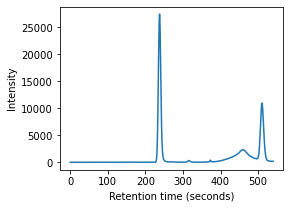

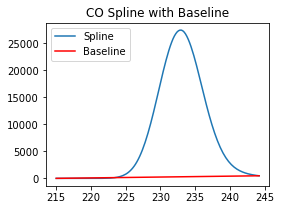

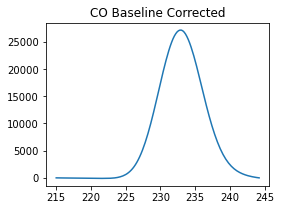

209193.75482320512
CH4
no peak
C2H4


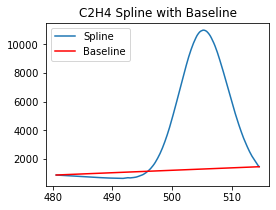

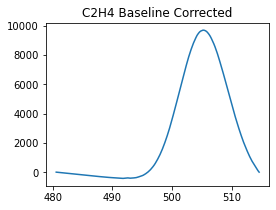

85730.00809413577
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD01.ASC
H2


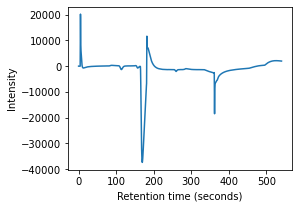

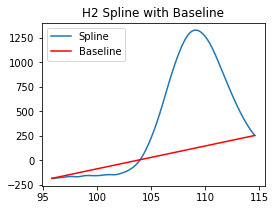

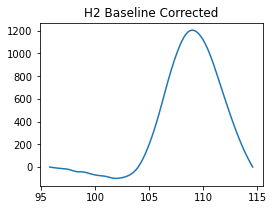

6464.378036199331
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID02.ASC
CO


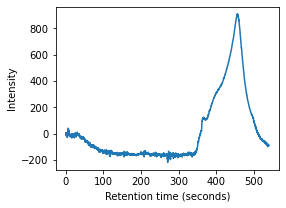

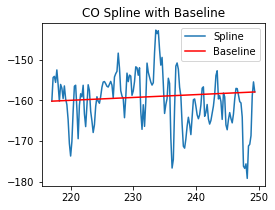

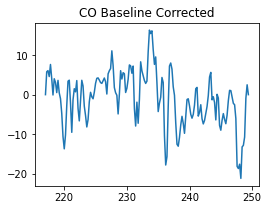

-29.839781430416398
CH4
no peak
C2H4


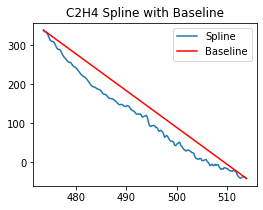

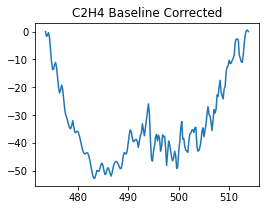

-1341.7435344264934
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD02.ASC
H2


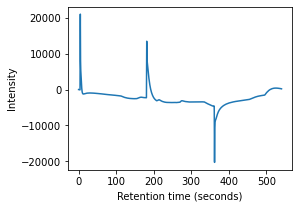

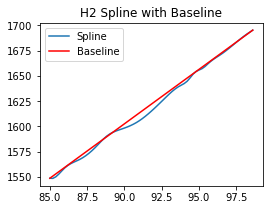

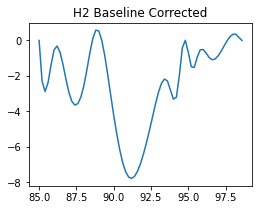

-32.86298730061894
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID03.ASC
CO


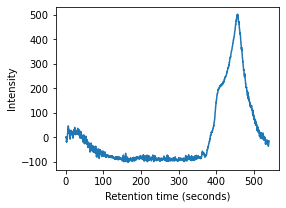

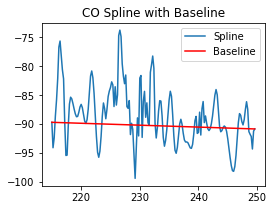

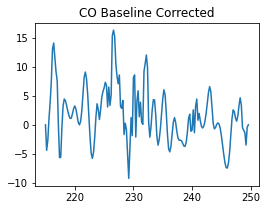

59.47170434670679
CH4
no peak
C2H4


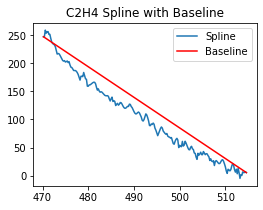

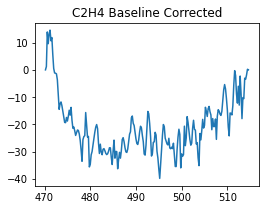

-923.0152112284579
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD03.ASC
H2


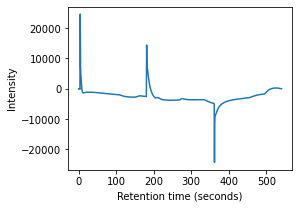

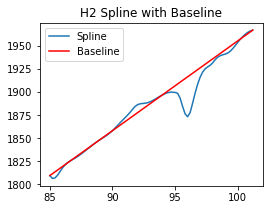

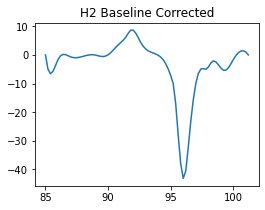

-57.30139051746564
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID04.ASC
CO


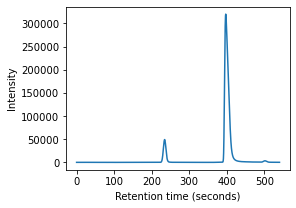

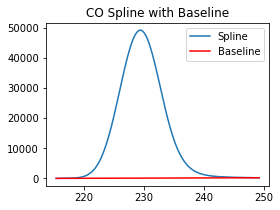

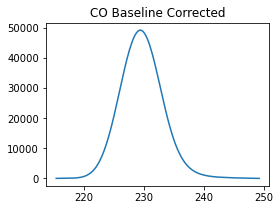

418625.1026818523
CH4
no peak
C2H4


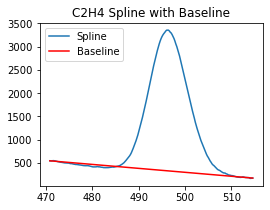

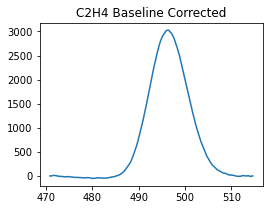

29801.95665654418
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD04.ASC
H2


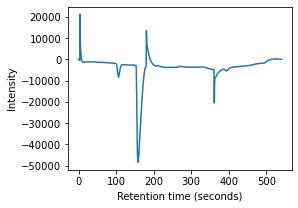

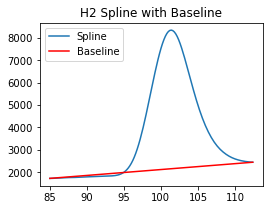

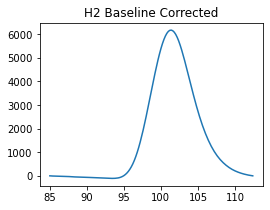

41207.084255760004
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID05.ASC
CO


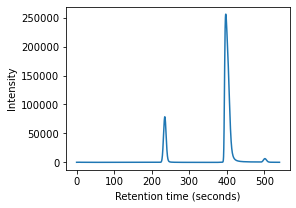

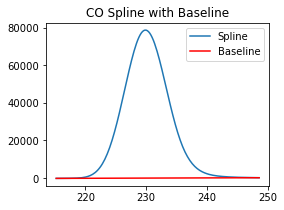

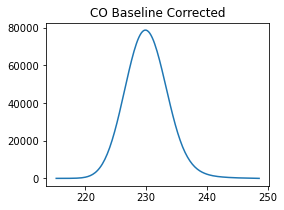

676508.9563256452
CH4
no peak
C2H4


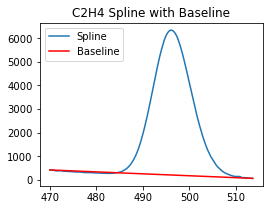

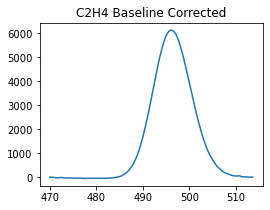

60902.41411803191
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD05.ASC
H2


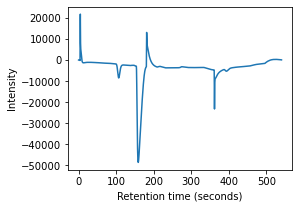

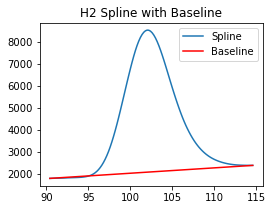

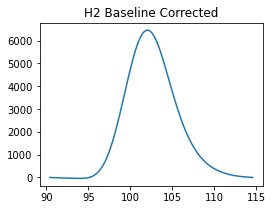

44604.97432693267
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}, 5: {'CO': 676508.9563256452, 'CH4': 0, 'C2H4': 60902.41411803191, 'H2': -44604.97432693267}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID06.ASC
CO


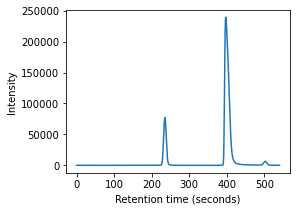

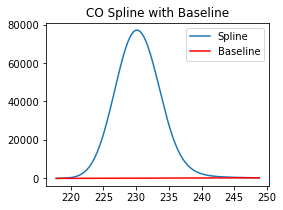

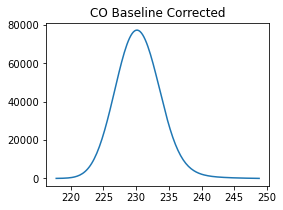

655316.6307902983
CH4
no peak
C2H4


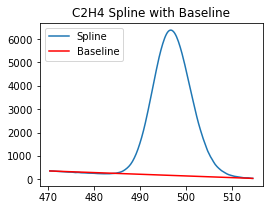

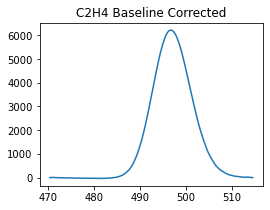

63067.842832139024
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD06.ASC
H2


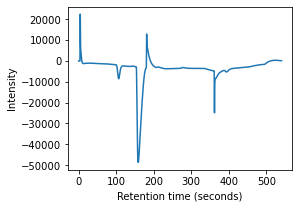

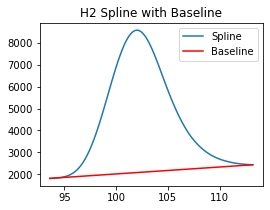

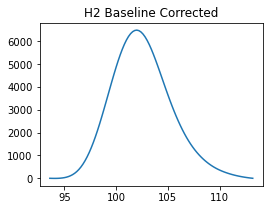

44639.693385844854
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}, 5: {'CO': 676508.9563256452, 'CH4': 0, 'C2H4': 60902.41411803191, 'H2': -44604.97432693267}, 6: {'CO': 655316.6307902983, 'CH4': 0, 'C2H4': 63067.842832139024, 'H2': -44639.693385844854}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID07.ASC
CO


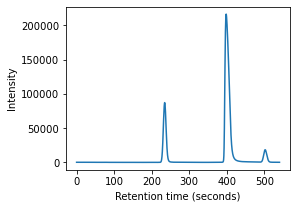

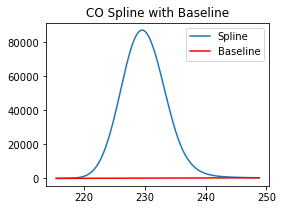

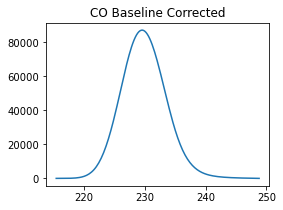

778652.6026099084
CH4
no peak
C2H4


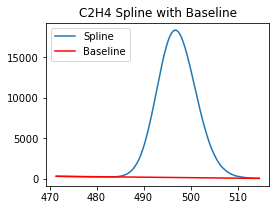

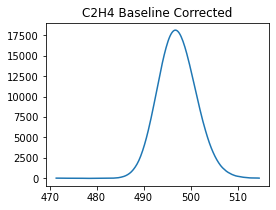

183654.16016342991
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD07.ASC
H2


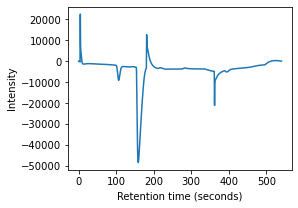

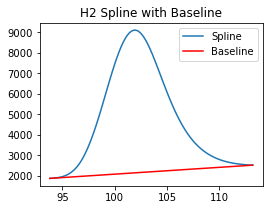

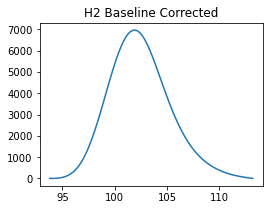

48245.964270393975
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}, 5: {'CO': 676508.9563256452, 'CH4': 0, 'C2H4': 60902.41411803191, 'H2': -44604.97432693267}, 6: {'CO': 655316.6307902983, 'CH4': 0, 'C2H4': 63067.842832139024, 'H2': -44639.693385844854}, 7: {'CO': 778652.6026099084, 'CH4': 0, 'C2H4': 183654.16016342991, 'H2': -48245.964270393975}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID08.ASC
CO


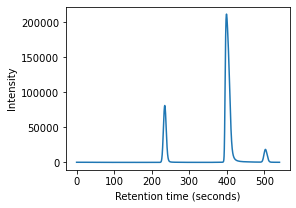

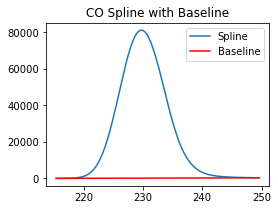

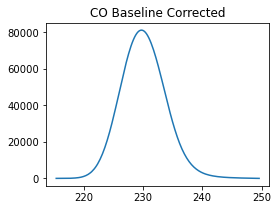

748579.4110745075
CH4
no peak
C2H4


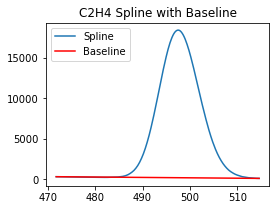

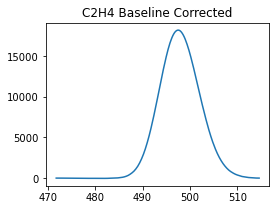

187017.5108346605
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD08.ASC
H2


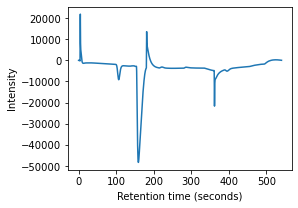

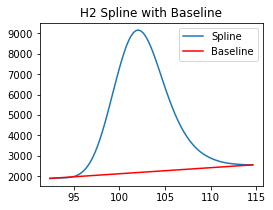

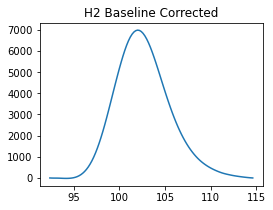

48835.951556039014
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}, 5: {'CO': 676508.9563256452, 'CH4': 0, 'C2H4': 60902.41411803191, 'H2': -44604.97432693267}, 6: {'CO': 655316.6307902983, 'CH4': 0, 'C2H4': 63067.842832139024, 'H2': -44639.693385844854}, 7: {'CO': 778652.6026099084, 'CH4': 0, 'C2H4': 183654.16016342991, 'H2': -48245.964270393975}, 8: {'CO': 748579.4110745075, 'CH4': 0, 'C2H4': 187017.5108346605, 'H2': -48835.951556039014}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-FID09.ASC
CO


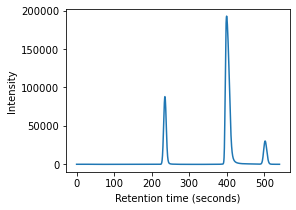

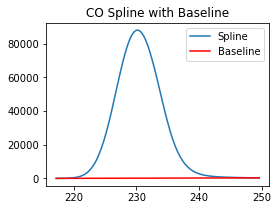

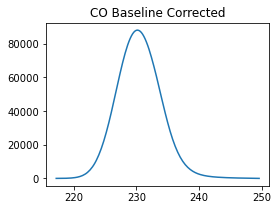

747876.5130054578
CH4
no peak
C2H4


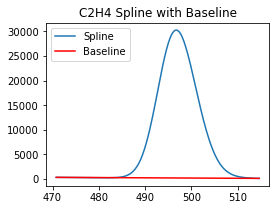

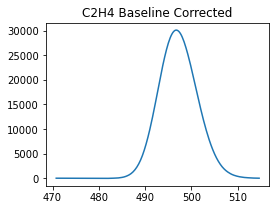

306905.31431460293
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD09.ASC
H2


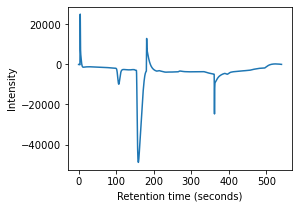

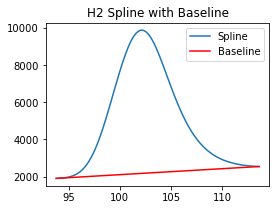

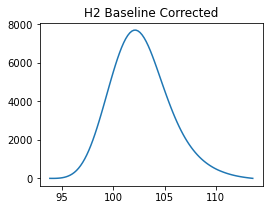

53394.07637842235
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}, 5: {'CO': 676508.9563256452, 'CH4': 0, 'C2H4': 60902.41411803191, 'H2': -44604.97432693267}, 6: {'CO': 655316.6307902983, 'CH4': 0, 'C2H4': 63067.842832139024, 'H2': -44639.693385844854}, 7: {'CO': 778652.6026099084, 'CH4': 0, 'C2H4': 183654.16016342991, 'H2': -48245.964270393975}, 8: {'CO': 748579.4110745075, 'CH4': 0, 'C2H4': 187017.5108346605, 'H2': -48835.951556039014}, 9: {'CO': 747876.5130054578, 'CH4': 0, 'C2H4': 306905.31431460293, 'H2': -53394.07637842235}}
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu

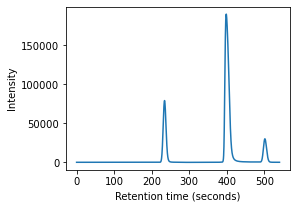

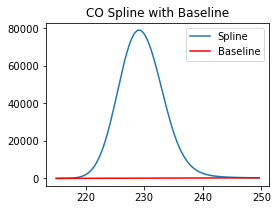

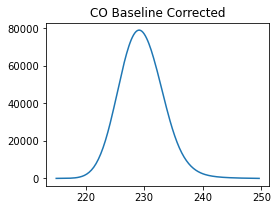

732607.9090228858
CH4
no peak
C2H4


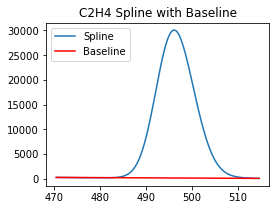

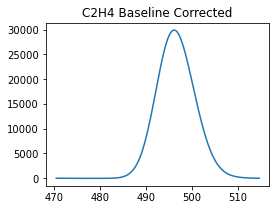

303306.745879945
C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3\JAR2-55B-TCD10.ASC
H2


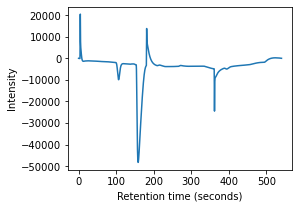

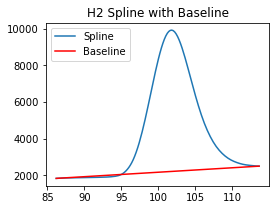

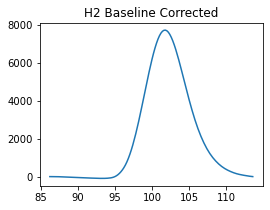

53032.8704200429
README {1: {'CO': 209193.75482320512, 'CH4': 0, 'C2H4': 85730.00809413577, 'H2': -6464.378036199331}, 2: {'CO': -29.839781430416398, 'CH4': 0, 'C2H4': -1341.7435344264934, 'H2': 32.86298730061894}, 3: {'CO': 59.47170434670679, 'CH4': 0, 'C2H4': -923.0152112284579, 'H2': 57.30139051746564}, 4: {'CO': 418625.1026818523, 'CH4': 0, 'C2H4': 29801.95665654418, 'H2': -41207.084255760004}, 5: {'CO': 676508.9563256452, 'CH4': 0, 'C2H4': 60902.41411803191, 'H2': -44604.97432693267}, 6: {'CO': 655316.6307902983, 'CH4': 0, 'C2H4': 63067.842832139024, 'H2': -44639.693385844854}, 7: {'CO': 778652.6026099084, 'CH4': 0, 'C2H4': 183654.16016342991, 'H2': -48245.964270393975}, 8: {'CO': 748579.4110745075, 'CH4': 0, 'C2H4': 187017.5108346605, 'H2': -48835.951556039014}, 9: {'CO': 747876.5130054578, 'CH4': 0, 'C2H4': 306905.31431460293, 'H2': -53394.07637842235}, 10: {'CO': 732607.9090228858, 'CH4': 0, 'C2H4': 303306.745879945, 'H2': -53032.8704200429}}


In [11]:
folder_path = r"C:\Users\jgage\OneDrive - Stanford\Kanan Group\Electrochemical Data\JAR2-55 Config 2 - NiFeOH Dai Lab Prep Anode 1 - 700 ug Cu-PTFE GDE - 2M Cs2CO3 1M CsHCO3"
# folder_path = ''

handle_GC_data(folder_path
    ,26, 5424, # overallleft, overallright,
    215, 250, 50, # COleft, COright, COthresh,
    246, 261, 150000, # CH4left, CH4right, CH4thresh,
    470, 515, 50, # C2H4left, C2H4right, C2H4thresh,
    85, 115, 20, # H2left, H2right, H2thresh
    100) # smooth